In [1]:
import netgen.gui
from ngsolve import *
import numpy as np
import scipy.sparse as sp
from math import pi
from numpy import linalg as LA
import matplotlib.pyplot as plt

### Erstellt ein Quadrat mit der Länge $1$ 
### und setzt einen Impuls in der Mitte des Quadrats

In [2]:
import netgen.geom2d as geom2dim
geo = geom2dim.SplineGeometry()
a = 1
points = [(0,0),(a,0),(a,a),(0,a)]
p1,p2,p3,p4 = [geo.AppendPoint(*pnt) for pnt in points]
curves = [['line',p1,p2],['line',p2,p3],['line',p3,p4],['line',p4,p1]]
[geo.Append(c) for c in curves]

mesh = Mesh(geo.GenerateMesh(maxh = 0.1))


piha = a/2
shift = 0
source = exp(-50**2*((x-piha-shift)*(x-piha-shift)+(y-piha-shift)*(y-piha-shift)))
Draw(source,mesh,name = "pulse")

In [3]:
maxind = 20
fes = H1(mesh, order=5)
#fes = H1(mesh, order=5,dirichlet=".*")
gfu = GridFunction(fes,name = "u")
erg = np.zeros([len(gfu.vec),maxind])
fh = np.zeros([len(gfu.vec),maxind])

### Die helmholzgleichung:
$\Delta u - \omega^2 u = f$
### und die Schwache Formulierung:
$\int_{\Omega}\nabla u \nabla v - \omega^2\int_{\Omega}u v = \int_{\Omega}fv$ $v \in V$
### löse die obrige Gleichung mit paar $\omega_i$ und speichere diese $u_i$ in eine Matrix 

In [4]:
u = fes.TrialFunction()
v = fes.TestFunction()

A = BilinearForm(fes)
K = BilinearForm(fes)
M = BilinearForm(fes)
F = LinearForm(fes)

omega = Parameter(1)
A += (grad(u)*grad(v)- omega**2*u*v)*dx
K += grad(u)*grad(v)*dx
M += u*v*dx


#A += 1j*omega*u*v*ds # R 
F += source*v*dx  
o = []  

norm = []
for i in range(0,maxind):
    o.append(i)
j = 0
Draw(gfu)
for i in o:   
    omega.Set(i) 
    A.Assemble()
    K.Assemble()
    M.Assemble()
    F.Assemble()   
    gfu.vec.data = A.mat.Inverse(fes.FreeDofs()) * F.vec
    erg[:,j] = gfu.vec
    fh[:,j] = F.vec
    norm.append(sqrt (Integrate ((gfu)*(gfu),mesh)))
    print("Number of iter: ",j,"omega: ",i,"L2-Norm:",sqrt (Integrate ((gfu)*(gfu),mesh)))
    j = j+1
Ms = M.mat
Ks = K.mat
rows,cols,vals = Ms.COO()
Mh = sp.csr_matrix((vals,(rows,cols)))
rows,cols,vals = Ks.COO()
Kh = sp.csr_matrix((vals,(rows,cols)))

Number of iter:  0 omega:  0 L2-Norm: 116094539143.60098
Number of iter:  1 omega:  1 L2-Norm: 0.0012512684752141298
Number of iter:  2 omega:  2 L2-Norm: 0.0003231626247758125
Number of iter:  3 omega:  3 L2-Norm: 0.00016788149776646608
Number of iter:  4 omega:  4 L2-Norm: 0.00014116616117545506
Number of iter:  5 omega:  5 L2-Norm: 0.00018783480392257503
Number of iter:  6 omega:  6 L2-Norm: 0.0007192272070600409
Number of iter:  7 omega:  7 L2-Norm: 0.0002783987361936216
Number of iter:  8 omega:  8 L2-Norm: 0.00019991530165594908
Number of iter:  9 omega:  9 L2-Norm: 0.0012152471294392337
Number of iter:  10 omega:  10 L2-Norm: 0.00013919399076116055
Number of iter:  11 omega:  11 L2-Norm: 0.0001081043741403241
Number of iter:  12 omega:  12 L2-Norm: 0.00019572005755279936
Number of iter:  13 omega:  13 L2-Norm: 0.00025730236187653747
Number of iter:  14 omega:  14 L2-Norm: 0.0024881506155264
Number of iter:  15 omega:  15 L2-Norm: 0.00013934446817779708
Number of iter:  16 omega:

In [5]:
V, r = np.linalg.qr(erg)
V = erg.dot(np.linalg.inv(r))
print(V[:,1].dot(V[:,2]))
len(V)

-6.456640777585676e-15


2976

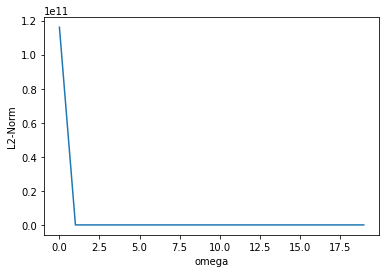

In [6]:
plt.plot(o,norm)
plt.xlabel("omega")
plt.ylabel("L2-Norm")
plt.savefig('results/resonanz_20.png')

### Für die erste Metode GramSchmid verwenden um eine orthonormale Koordinatentransformationsmatrix zu erstellen(Euklidische Norm). 

$$
M_N = V^T \cdot M_h \cdot V
$$

$$
K_N = V^T \cdot K_h \cdot V
$$

$$
f_N = V^T \cdot f_h
$$

$$
u_i = (K_N - \omega^2_iM_N)^{-1} \cdot f_N
$$

In [7]:
MN = np.transpose(V).dot(Mh.dot(V))
KN = np.transpose(V).dot(Kh.dot(V))
fN = np.transpose(V).dot(fh)

In [ ]:
iteration = int(1e4)
interval = 20
factor = interval / iteration
omegaN = []
norm_L2 =[]
uN = np.zeros([maxind,iteration])
for i in range(iteration):
    omegaN.append(factor*i)
    uN[:,i] = np.linalg.solve(KN-omegaN[i]**2*MN, fN[0])
    new = uN[:,i].dot(np.transpose(V))
    gif = GridFunction(fes,name = "gif")
    gif.vec.FV().NumPy()[:] = new
    Draw(gif)
    print("Omega: ",omegaN[i])
    input()
    Redraw()
    norm_L2.append(sqrt(uN[:,i].dot(uN[:,i])))

In [9]:
maxind = 20
iteration = int(1e4)
interval = 20
factor = interval / iteration
omegaN = []
norm_L2 =[]
res = []
uN = np.zeros([maxind,iteration])
for i in range(iteration):
    omegaN.append(factor*i)
    uN[:,i] = np.linalg.solve(KN-omegaN[i]**2*MN, fN[0])
    res.append(np.linalg.norm((Kh-omegaN[i]**2*Mh).dot(uN[:,i].dot(np.transpose(V)))-fN[0].dot(np.transpose(V))))
    norm_L2.append(sqrt(uN[:,i].dot(uN[:,i])))

In [ ]:
plt.semilogy(omegaN,norm_L2)
plt.xlabel("omega")
plt.ylabel("L2-Norm")
plt.savefig('results/resonanz_RB_20.png')

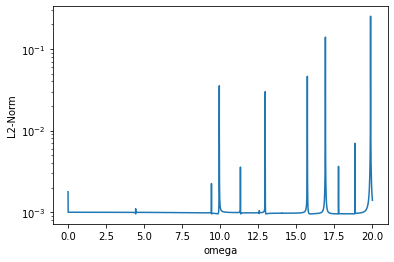

In [10]:
plt.semilogy(omegaN,res)
plt.xlabel("omega")
plt.ylabel("L2-Norm")
plt.savefig('results/resonanz_RB_20.png')

In [13]:
j = 0
res = np.zeros(maxind)
for fre in o:
    uN[:,j] = np.linalg.solve(KN-fre**2*MN, fN[j])
    res[j] = np.linalg.norm((Kh-fre**2*Mh).dot(uN[:,j].dot(np.transpose(V)))-fh[:,j])
    j = j+1

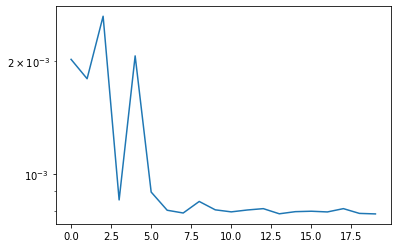

In [14]:
plt.semilogy(o,res)

In [ ]:
res

In [ ]:
o

In [ ]:
newomega = []
dicht = 10
for i in range(len(res)):
    if(res[i] > 0.01):
        temp = i
        for j in range(1,dicht):
            newomega.append(temp-1+(1/dicht)*j)
    else:
        newomega.append(i)

In [ ]:
len(newomega)

In [ ]:
for i in range(1000):
    new = uN[:,i*300].dot(np.transpose(V))
    gif = GridFunction(fes,name = "gif")
    gif.vec.FV().NumPy()[:] = new
    Draw(gif)
    input()